In [158]:
%matplotlib widget

# загрузим данные
import numpy as np
import pandas as pd

file_path = "../npz/BTCUSD_1T_close_only.npz"
data = np.load(file_path, allow_pickle=True)
df = pd.DataFrame(data['data'], columns=['timestamp', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['close'] = df['close'].astype(float)
df.set_index('timestamp', inplace=True)

In [194]:
dfc = df[:100000].copy()
#dfc['close'] = np.log(dfc['close'])
dfc['close'] = np.log(dfc['close']) - np.log(dfc['close'].iloc[0])

In [195]:
from itertools import islice

def get_transitions_map(df, windows, tau, grid_sizes, transitions_grid_size):
    """
    creates a map of price shifts
    """
    max_window = max(windows)
    mas = {}
    diffs = {}
    closes = df['close']
    transition_values = closes.shift(-tau) - closes
    transitions_min = transition_values.min()
    transitions_max = transition_values.max()
    for wi, w in enumerate(windows):
        mas[wi] = closes.rolling(w).mean() if w > 0 else closes
        if wi > 0:
            diffs[wi] = mas[wi] - mas[wi - 1]
    diff_mins = [0]
    diff_maxs = [0]
    for wi, w in islice(enumerate(windows), 1, None):
        diff_mins.append(diffs[wi].min())
        diff_maxs.append(diffs[wi].max())
    transitions = {}
    transitions_map = {}
    for i in range(max_window, len(df) - tau):
        positions = []
        for wi, w in islice(enumerate(windows), 1, None):
            diff = diffs[wi].iloc[i]
            diff_min = diff_mins[wi]
            diff_max = diff_maxs[wi]
            grid_size = grid_sizes[wi]

            # Avoid division by zero and ensure diff_max > diff_min
            if diff_max == diff_min:
                pos_fixed = 0
            else:
                pos = (grid_size - 1) * (diff - diff_min) / (diff_max - diff_min)
                pos_fixed = max(0, min(round(pos), grid_size - 1))  # Ensure position is within bounds

            positions.append(pos_fixed)

        # Calculate transition position
        transition_value = transition_values.iloc[i]
        if transitions_max == transitions_min:
            transitions_pos_fixed = 0
        else:
            transitions_pos = (transitions_grid_size - 1) * (transition_value - transitions_min) / (transitions_max - transitions_min)
            transitions_pos_fixed = max(0, min(round(transitions_pos), transitions_grid_size - 1))

        # Update transitions_map
        if tuple(positions) not in transitions_map:
            transitions_map[tuple(positions)] = {}
        if transitions_pos_fixed not in transitions_map[tuple(positions)]:
            transitions_map[tuple(positions)][transitions_pos_fixed] = 1
        else:
            transitions_map[tuple(positions)][transitions_pos_fixed] += 1
    return transitions, diff_mins, diff_maxs, transitions_map, transitions_min, transitions_max

transitions, _, _, transitions_map, _, _ = get_transitions_map(dfc, [30, 60, 120], 10, [9, 9, 9], 99)
transitions

{}

In [ ]:
# Filter out transitions with low frequencies
def filter_low_frequency_transitions(transitions_map, threshold):
    """
    Filters out transitions with frequencies below the given threshold.
    
    Args:
        transitions_map (dict): The transitions map to filter.
        threshold (int): The minimum frequency threshold.
    
    Returns:
        dict: A filtered transitions map.
    """
    filtered_map = {}
    for positions, counts in transitions_map.items():
        # Filter out transitions with counts below the threshold
        filtered_counts = {k: v for k, v in counts.items() if v >= threshold}
        if filtered_counts:  # Only include positions with valid counts
            filtered_map[positions] = filtered_counts
    return filtered_map

# Apply the filter with a threshold of 10
filtered_transitions_map = filter_low_frequency_transitions(transitions_map, threshold=50)

#transitions_map
filtered_transitions_map

{(3, 5): {66: 80, 65: 51, 67: 147, 68: 176, 69: 122, 70: 76, 71: 59},
 (3, 4): {69: 3803,
  68: 8216,
  67: 10383,
  66: 6158,
  65: 2741,
  64: 1223,
  70: 1623,
  71: 676,
  72: 324,
  63: 588,
  62: 302,
  61: 151,
  59: 53,
  58: 52,
  60: 94,
  74: 100,
  73: 147,
  76: 53,
  75: 71},
 (3, 3): {67: 15641,
  65: 4011,
  66: 9834,
  68: 10706,
  62: 331,
  64: 1535,
  61: 173,
  63: 712,
  60: 104,
  71: 744,
  69: 4493,
  70: 1841,
  72: 385,
  74: 132,
  73: 242,
  76: 64,
  77: 53,
  75: 100,
  59: 51},
 (4, 4): {69: 228,
  68: 285,
  67: 260,
  66: 256,
  64: 112,
  65: 182,
  70: 160,
  71: 99,
  72: 77,
  63: 76},
 (4, 5): {67: 52},
 (2, 4): {66: 103, 67: 123, 68: 90},
 (2, 3): {64: 262,
  66: 582,
  67: 684,
  68: 555,
  65: 392,
  62: 101,
  63: 162,
  70: 198,
  69: 342,
  72: 62,
  71: 105,
  73: 63},
 (2, 2): {66: 103, 64: 54, 65: 75, 67: 125, 68: 120, 69: 73, 70: 52},
 (3, 2): {69: 103, 70: 59, 66: 151, 68: 103, 64: 74, 67: 178, 65: 118}}

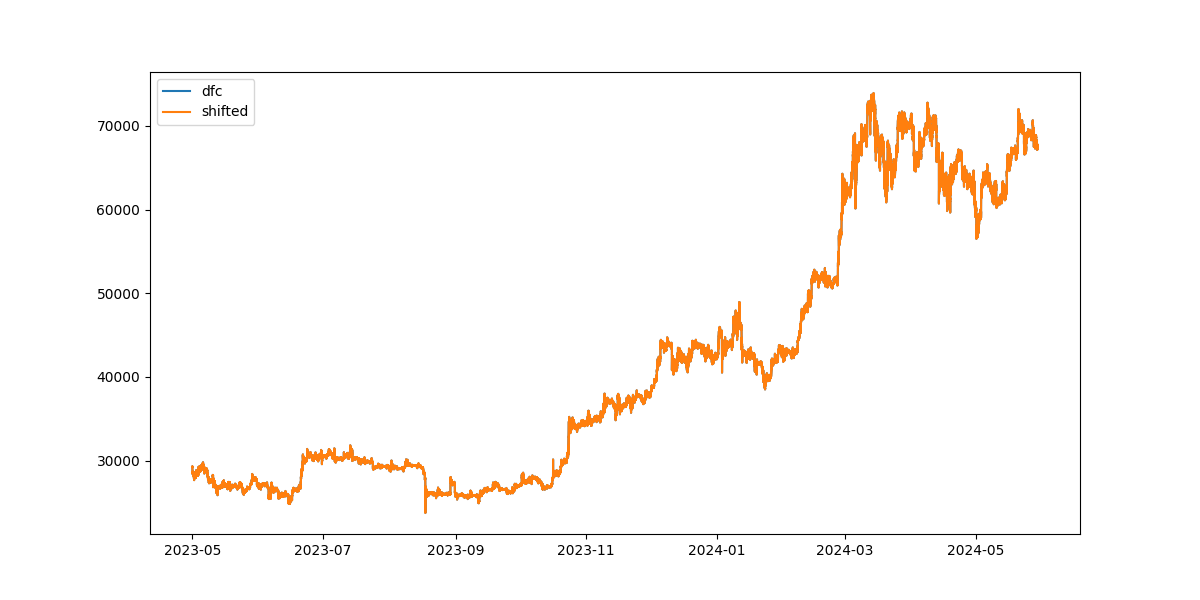

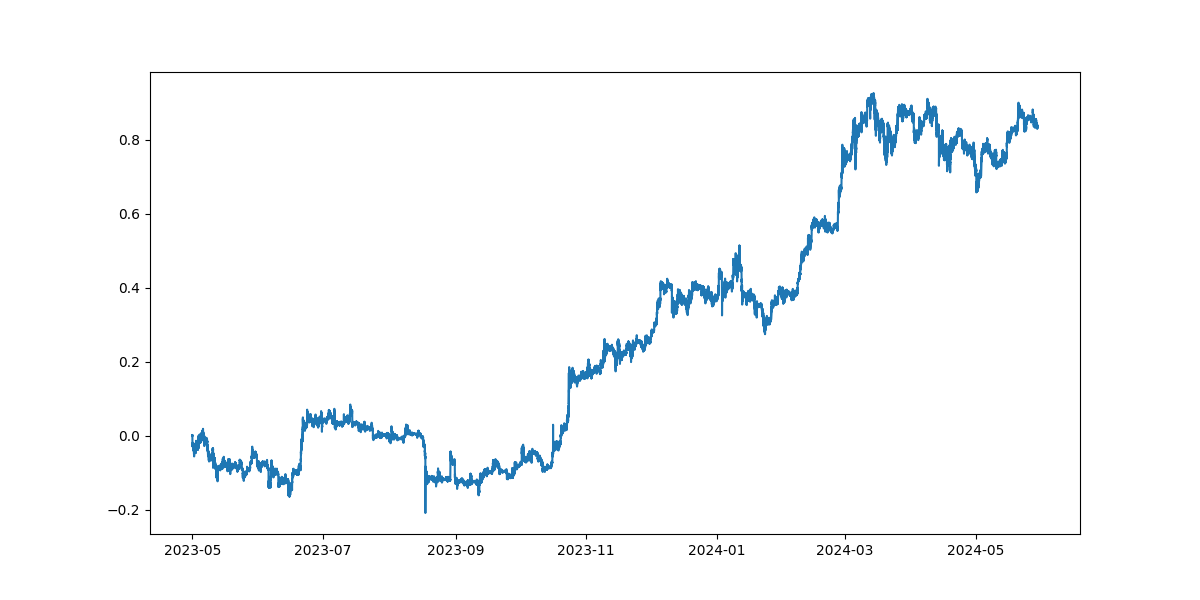

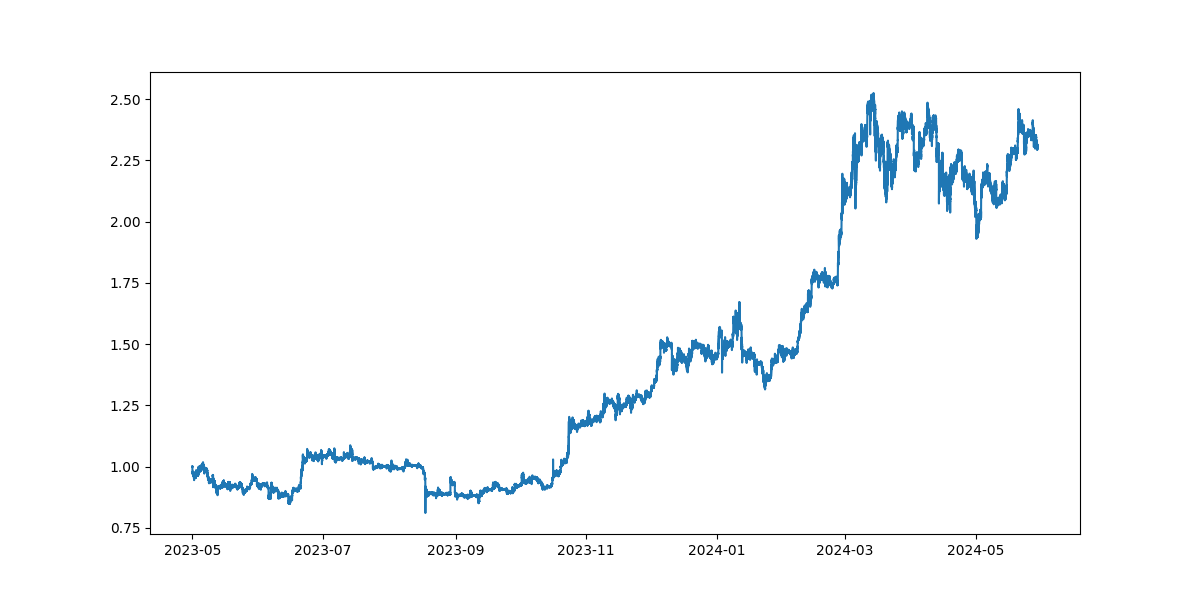

In [198]:
dfc = df.copy()
log_returns = np.log(dfc['close'] / dfc['close'].shift(1))[1:]
log_price = log_returns.cumsum()
rel_price = np.exp(log_price - log_price.iloc[0])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dfc, label='dfc')
plt.plot(dfc.shift(1), label='shifted')
plt.legend()
plt.figure(figsize=(12, 6))
plt.plot(log_price, label='log_price')
plt.figure(figsize=(12, 6))
plt.plot(rel_price, label='rel_price')


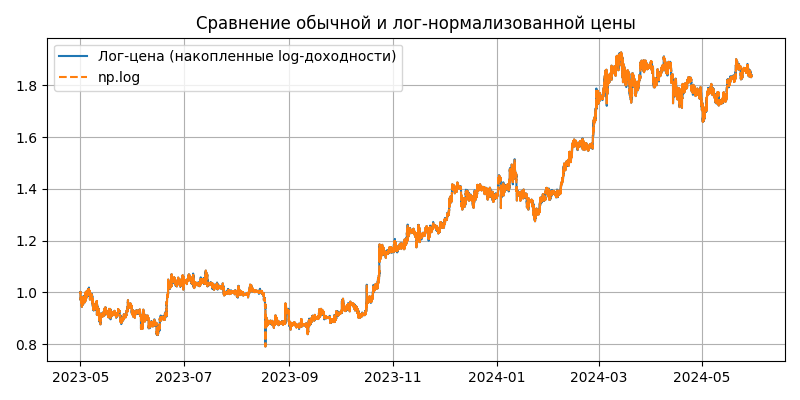

In [199]:
import numpy as np
import matplotlib.pyplot as plt

log_returns = np.log(dfc['close'] / dfc['close'].shift(1))[1:]#.dropna()
log_price = log_returns.cumsum()
#log_price -= log_price.iloc[0]  # нормировка: стартуем с 0
#rel_price = np.exp(log_price)  # условная "цена" в относительных единицах

log_abs = np.log(dfc['close'])

plt.figure(figsize=(8, 4))
#plt.yscale('log')
# plt.plot(dfc.index, dfc['close'] / dfc['close'].iloc[0], label='Оригинальная цена', alpha=0.6)
# plt.plot(log_price.index, rel_price, label='Нормированная цена (exp(cumsum(log return)))', alpha=0.8)
plt.plot(log_price.index, log_price + 1, label='Лог-цена (накопленные log-доходности)')
plt.plot(log_price.index, (log_abs - log_abs.iloc[0] + 1)[1:], label='np.log', linestyle='--')
plt.legend()
plt.grid(True)
plt.title("Сравнение обычной и лог-нормализованной цены")
plt.tight_layout()
plt.show()
